# **LOAD LIBARY**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [5]:
pip install Sastrawi


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached Sastrawi-1.0.1-py2.py3-none-any.whl (209 kB)


In [2]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reyhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **LOAD DATASET**

In [16]:
data = pd.read_excel('dataset_sentimen.xlsx')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_sentimen.xlsx'

In [6]:
df_proses = data
df_proses.isnull().sum()

NameError: name 'data' is not defined

In [ ]:
df_proses.dropna(inplace=True)
df_proses['keyakinan'].describe(), df_proses['subreddit'].unique()

(count    2834.000000
 mean        0.808995
 std         0.177071
 min         0.428571
 25%         0.600000
 50%         0.800000
 75%         1.000000
 max         1.000000
 Name: keyakinan, dtype: float64,
 array(['ptsd', 'bantuan', 'hubungan', 'survivorsofabuse',
        'kekerasan dalam rumah tangga', 'kecemasan', 'tunawisma', 'stres',
        'almosthomeless', 'food_pantry'], dtype=object))

In [ ]:
df_proses.isnull().sum()

subreddit    0
teks         0
label        0
keyakinan    0
dtype: int64

# **PREPROCESSING**

### **1. CASE FOLDING**

In [ ]:
def casefolding(text):
    text = text.lower()
    text = re.sub(r'[-+]?[0-9]+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.strip()
    return text

In [ ]:
case_folding = df_proses['teks'].apply(casefolding)

print('Raw Data:')
print(df_proses['teks'])

print('\nCase Folding:')
print(case_folding)

Raw Data:
0       Dia mengatakan bahwa dia belum pernah merasaka...
1       Halo r/assistance, Tidak yakin apakah ini temp...
2       Ibu saya kemudian memukul saya dengan koran da...
3       sampai saya bertemu dengan pacar baru saya, di...
4       Bulan Oktober adalah Bulan Kesadaran Kekerasan...
                              ...                        
2833    * Dia, seminggu yang lalu: Berharga, apa kabar...
2834    Saya tidak memiliki kemampuan untuk mengatasin...
2835    Jika ini adalah pertama kalinya Anda membaca p...
2836    Apakah menurut Anda ini normal? Mereka memilik...
2837    Saya sedang berbicara dengan ibu saya pagi ini...
Name: teks, Length: 2834, dtype: object

Case Folding:
0       dia mengatakan bahwa dia belum pernah merasaka...
1       halo rassistance tidak yakin apakah ini tempat...
2       ibu saya kemudian memukul saya dengan koran da...
3       sampai saya bertemu dengan pacar baru saya dia...
4       bulan oktober adalah bulan kesadaran kekerasan...
       

### **2. STOPWORD REMOVAL**

In [ ]:
stopwords_ind = stopwords.words('indonesian')

In [ ]:
def remove_stopword(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)

In [ ]:
stopword_removal = case_folding.apply(remove_stopword)

print(case_folding.head())
print(stopword_removal.head())

0    dia mengatakan bahwa dia belum pernah merasaka...
1    halo rassistance tidak yakin apakah ini tempat...
2    ibu saya kemudian memukul saya dengan koran da...
3    sampai saya bertemu dengan pacar baru saya dia...
4    bulan oktober adalah bulan kesadaran kekerasan...
Name: teks, dtype: object
0    merasakan menyarankan beristirahat hipokondrik...
1    halo rassistance memposting magang sandia nati...
2    memukul koran mengejutkan suka bermain memukul...
3    bertemu pacar manis murid menyukai halhal kelu...
4    oktober kesadaran kekerasan rumah tangga penyi...
Name: teks, dtype: object


### **3. STEMMING**

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    text = stemmer.stem(text)
    return text

In [ ]:
text_stemming = stopword_removal.apply(stemming)

print(df_proses["teks"].head())
print(text_stemming.head())

0    Dia mengatakan bahwa dia belum pernah merasaka...
1    Halo r/assistance, Tidak yakin apakah ini temp...
2    Ibu saya kemudian memukul saya dengan koran da...
3    sampai saya bertemu dengan pacar baru saya, di...
4    Bulan Oktober adalah Bulan Kesadaran Kekerasan...
Name: teks, dtype: object
0    rasa saran istirahat hipokondrik putus cari as...
1    halo rassistance memposting magang sandia nati...
2    pukul koran kejut suka main pukul tampar colok...
3    temu pacar manis murid suka halhal keluarga su...
4    oktober sadar keras rumah tangga sintas keras ...
Name: teks, dtype: object


### **4. PIPELINE**

In [ ]:
def text_preprocessing(text):
    if isinstance(text, str):
        text = casefolding(text)
        text = remove_stopword(text)
        text = stemming(text)
        return text
    elif isinstance(text, np.ndarray):
        return np.vectorize(text_preprocessing)(text)
    else:
        return text

In [ ]:
%%time
df_proses['clean_teks'] = df_proses['teks'].apply(text_preprocessing)

CPU times: total: 984 ms
Wall time: 1.06 s


In [ ]:
df_proses

,subreddit,teks,label,keyakinan,clean_teks
0,ptsd,Dia mengatakan bahwa dia belum pernah merasaka...,1,0.800000,rasa saran istirahat hipokondrik putus cari as...
1,bantuan,"Halo r/assistance, Tidak yakin apakah ini temp...",0,1.000000,halo rassistance memposting magang sandia nati...
2,ptsd,Ibu saya kemudian memukul saya dengan koran da...,1,0.800000,pukul koran kejut suka main pukul tampar colok...
3,hubungan,"sampai saya bertemu dengan pacar baru saya, di...",1,0.600000,temu pacar manis murid suka halhal keluarga su...
4,survivorsofabuse,Bulan Oktober adalah Bulan Kesadaran Kekerasan...,1,0.800000,oktober sadar keras rumah tangga sintas keras ...
...,...,...,...,...,...
2833,hubungan,"* Dia, seminggu yang lalu: Berharga, apa kabar...",0,1.000000,minggu harga kabar abai januari bahagia harga ...
2834,ptsd,Saya tidak memiliki kemampuan untuk mengatasin...,1,1.000000,milik mampu atas coba picu henti kerja temu am...
2835,kecemasan,Jika ini adalah pertama kalinya Anda membaca p...,0,1.000000,kali baca posting cari orangorang sedia isi ku...
2836,almosthomeless,Apakah menurut Anda ini normal? Mereka memilik...,0,0.571429,normal milik hubung utama milik ibu pakai penj...


In [ ]:
df_proses.to_csv('Dataset/clean_data.csv')

### **5. FEAUTURE EXTRACTION**

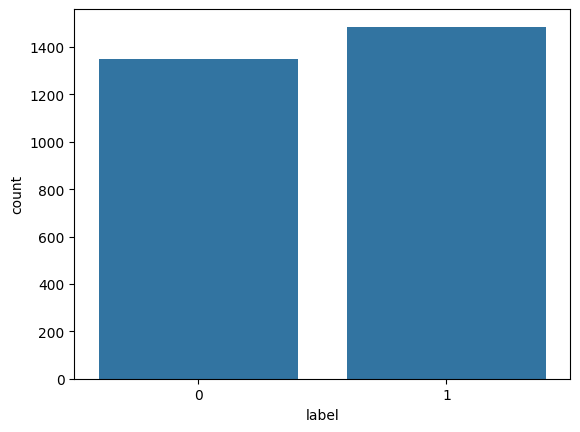

label
1    1486
0    1348
Name: count, dtype: int64


In [ ]:
sns.countplot(x='label', data=data)
plt.show()

label_counts = df_proses['label'].value_counts()
print(label_counts)

In [ ]:
label_counts = df_proses['label'].value_counts()

min_count = min(label_counts)

rows_to_drop = df_proses[df_proses['label'] == 1].sample(frac=1 - min_count / label_counts[1], random_state=42).index

df_proses = df_proses.drop(rows_to_drop)

print(df_proses['label'].value_counts())
df_proses

label
1    1348
0    1348
Name: count, dtype: int64


,subreddit,teks,label,keyakinan,clean_teks
0,ptsd,Dia mengatakan bahwa dia belum pernah merasaka...,1,0.800000,rasa saran istirahat hipokondrik putus cari as...
1,bantuan,"Halo r/assistance, Tidak yakin apakah ini temp...",0,1.000000,halo rassistance memposting magang sandia nati...
2,ptsd,Ibu saya kemudian memukul saya dengan koran da...,1,0.800000,pukul koran kejut suka main pukul tampar colok...
3,hubungan,"sampai saya bertemu dengan pacar baru saya, di...",1,0.600000,temu pacar manis murid suka halhal keluarga su...
4,survivorsofabuse,Bulan Oktober adalah Bulan Kesadaran Kekerasan...,1,0.800000,oktober sadar keras rumah tangga sintas keras ...
...,...,...,...,...,...
2833,hubungan,"* Dia, seminggu yang lalu: Berharga, apa kabar...",0,1.000000,minggu harga kabar abai januari bahagia harga ...
2834,ptsd,Saya tidak memiliki kemampuan untuk mengatasin...,1,1.000000,milik mampu atas coba picu henti kerja temu am...
2835,kecemasan,Jika ini adalah pertama kalinya Anda membaca p...,0,1.000000,kali baca posting cari orangorang sedia isi ku...
2836,almosthomeless,Apakah menurut Anda ini normal? Mereka memilik...,0,0.571429,normal milik hubung utama milik ibu pakai penj...


In [ ]:
x = df_proses['clean_teks']
y = df_proses['label']
print(x.head(), y.head())

0    rasa saran istirahat hipokondrik putus cari as...
1    halo rassistance memposting magang sandia nati...
2    pukul koran kejut suka main pukul tampar colok...
3    temu pacar manis murid suka halhal keluarga su...
4    oktober sadar keras rumah tangga sintas keras ...
Name: clean_teks, dtype: object 0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64


In [ ]:
x.describe(), y.describe()

(count                                                  2696
 unique                                                 2680
 top       halo undang selesai survei proyek teliti depar...
 freq                                                      4
 Name: clean_teks, dtype: object,
 count    2696.000000
 mean        0.500000
 std         0.500093
 min         0.000000
 25%         0.000000
 50%         0.500000
 75%         1.000000
 max         1.000000
 Name: label, dtype: float64)

### **5.1 TF-Idf dan N-Gram**

In [ ]:
vec_TF_IDF = TfidfVectorizer(ngram_range=(1,1))
vec_TF_IDF.fit(x)

x_tf_idf = vec_TF_IDF.transform(x)

pickle.dump(vec_TF_IDF.vocabulary_,open("Model/Feautue_tf-idf.sav","wb"))

In [ ]:
vec_TF_IDF.vocabulary_

{'rasa': 4379,
 'saran': 4668,
 'istirahat': 2145,
 'hipokondrik': 1902,
 'putus': 4311,
 'cari': 839,
 'asa': 289,
 'kiamat': 2583,
 'harap': 1830,
 'sedot': 4751,
 'lubang': 3073,
 'konspirasi': 2695,
 'konyol': 2719,
 'tes': 5481,
 'bodoh': 692,
 'cenayang': 871,
 'new': 3625,
 'age': 65,
 'bs': 740,
 'tertawa': 5474,
 'baca': 365,
 'malapetaka': 3150,
 'indikasi': 2023,
 'sakit': 4607,
 'sehat': 4758,
 'salah': 4614,
 'satu': 4681,
 'alami': 115,
 'suram': 5230,
 'khawatir': 2578,
 'jantung': 2208,
 'periksa': 4009,
 'fisik': 1520,
 'jam': 2190,
 'halo': 1811,
 'rassistance': 4385,
 'memposting': 3293,
 'magang': 3118,
 'sandia': 4647,
 'national': 3599,
 'labs': 2842,
 'survei': 5237,
 'bantu': 436,
 'tingkat': 5530,
 'upaya': 5753,
 'jangkau': 2204,
 'pasar': 3882,
 'sekolah': 4771,
 'rekrut': 4442,
 'negeri': 3607,
 'mahasiswa': 3122,
 'stem': 5147,
 'ss': 5124,
 'kenal': 2501,
 'harga': 1833,
 'isi': 2136,
 'sebar': 4733,
 'singkat': 5002,
 'ucap': 5704,
 'terima': 5450,
 'kasi

In [ ]:
print(len(vec_TF_IDF.get_feature_names_out()))

6000


In [ ]:
print(vec_TF_IDF.get_feature_names_out())

['aa' 'abadi' 'abah' ... 'zona' 'zuko' 'zumba']


In [ ]:
x1 = vec_TF_IDF.transform(x).toarray()
data_tabular_tf_idf = pd.DataFrame(x1,columns=vec_TF_IDF.get_feature_names_out())

data_tabular_tf_idf.tail

<bound method NDFrame.tail of        aa  abadi  abah      abai  abar  abb  abdi  aborsi  about  absah  ...  \
0     0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
1     0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
2     0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
3     0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
4     0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
...   ...    ...   ...       ...   ...  ...   ...     ...    ...    ...  ...   
2691  0.0    0.0   0.0  0.180518   0.0  0.0   0.0     0.0    0.0    0.0  ...   
2692  0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
2693  0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
2694  0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   
2695  0.0    0.0   0.0  0.000000   0.0  0.0   0.0     0.0    0.0    0.0  ...   

      zil

In [ ]:
data_tabular_tf_idf.iloc[40:50,1000:1010]

,cukupmeskipun,cukur,culik,cum,cumbu,cundang,cunt,cuping,cuplik,cups
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_tabular_tf_idf.describe()

,aa,abadi,abah,abai,abar,abb,abdi,aborsi,about,absah,...,zillow,zine,zinsserengmancole,zirah,zofran,zoloft,zombie,zona,zuko,zumba
count,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,...,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000,2696.000000
mean,0.000068,0.000243,0.000096,0.003470,0.000122,0.000089,0.000200,0.000110,0.000089,0.000097,...,0.000066,0.000104,0.000090,0.000214,0.000096,0.000956,0.000167,0.000311,0.000072,0.000053
std,0.003554,0.008931,0.005001,0.026219,0.006351,0.004605,0.008007,0.005705,0.004609,0.005040,...,0.003443,0.005406,0.004683,0.007858,0.004972,0.015328,0.006122,0.008508,0.003729,0.002760
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.184550,0.337288,0.259657,0.409075,0.329774,0.239121,0.386470,0.296208,0.239322,0.261705,...,0.178787,0.280715,0.243179,0.301923,0.258175,0.371833,0.226386,0.329255,0.193641,0.143296


### **5.2 FEATURES SELECTION**

In [ ]:
x_train = np.array(data_tabular_tf_idf)
y_train = np.array(y)

In [ ]:
y_train.shape

(2696,)

In [ ]:
chi2_features = SelectKBest(chi2, k=2000)
x_kbest_features = chi2_features.fit_transform(x_train,y_train)

print('Original Feature Number' , x_train.shape[1])
print('Reduce Feature Number ', x_kbest_features.shape[1])

Original Feature Number 6000
Reduce Feature Number  2000


In [ ]:
df_final = pd.DataFrame(chi2_features.scores_,columns=['Nilai'])
df_final

,Nilai
0,0.184550
1,0.000548
2,0.259657
3,0.362280
4,0.329774
...,...
5995,0.313593
5996,0.449624
5997,0.038104
5998,0.193641


In [ ]:
feature = vec_TF_IDF.get_feature_names_out()
feature

df_final['Fitur'] = feature
df_final

,Nilai,Fitur
0,0.184550,aa
1,0.000548,abadi
2,0.259657,abah
3,0.362280,abai
4,0.329774,abar
...,...,...
5995,0.313593,zoloft
5996,0.449624,zombie
5997,0.038104,zona
5998,0.193641,zuko


In [ ]:
df_final.sort_values(by='Nilai',ascending=False)

,Nilai,Fitur
5281,1.489415e+01,takut
5237,1.323218e+01,survei
866,1.244848e+01,cemas
524,9.535557e+00,benci
2399,8.993056e+00,kasih
...,...,...
1365,7.208362e-07,eksploitasi
1984,8.185801e-08,ijazah
186,1.314411e-08,and
2482,7.714408e-10,keluargateman


In [ ]:
mask = chi2_features.get_support()
mask

array([False, False, False, ..., False, False, False])

In [ ]:
new_feature =[]
for bool, f in zip(mask,feature):
    if bool :
        new_feature.append(f)
    selected_feature = new_feature
    
print(selected_feature)

['abai', 'abar', 'absen', 'acara', 'acau', 'ace', 'acu', 'acuh', 'ada', 'adalahdimana', 'adikadik', 'adopsi', 'advokasi', 'advokat', 'af', 'afghanistan', 'afiliasi', 'afinitas', 'agaim', 'agorafobia', 'agung', 'airbnb', 'aja', 'ajar', 'akademik', 'akal', 'akhir', 'akhirakhir', 'akomodasi', 'akses', 'akting', 'aktual', 'aku', 'alam', 'alami', 'alangkah', 'alaska', 'albumalbum', 'alex', 'alice', 'alj', 'alt', 'alternatif', 'aman', 'amanda', 'amat', 'amazon', 'amen', 'amharik', 'amsterdam', 'amuk', 'analis', 'ancam', 'anda', 'andal', 'andres', 'angeles', 'anggur', 'angin', 'angkaangka', 'angkuh', 'anna', 'annie', 'anonim', 'anoreksia', 'antah', 'anti', 'antidepresan', 'antisipasi', 'antisipatif', 'antisosial', 'antusias', 'anut', 'apaapa', 'apatis', 'apel', 'aplikasi', 'apoligizes', 'arah', 'area', 'argumentatif', 'artifisial', 'artikel', 'artikulasi', 'arus', 'asa', 'asam', 'asap', 'asinghanya', 'asisten', 'asli', 'aspergers', 'assistance', 'astaga', 'asuh', 'atap', 'atas', 'atautanyakan

In [ ]:
new_selected_feature = {}

for (k,v) in vec_TF_IDF.vocabulary_.items():
    if k in selected_feature:
        new_selected_feature[k]=v
        
print(new_selected_feature)

{'rasa': 4379, 'istirahat': 2145, 'asa': 289, 'sedot': 4751, 'lubang': 3073, 'bodoh': 692, 'bs': 740, 'baca': 365, 'malapetaka': 3150, 'indikasi': 2023, 'sakit': 4607, 'salah': 4614, 'alami': 115, 'khawatir': 2578, 'jantung': 2208, 'fisik': 1520, 'memposting': 3293, 'magang': 3118, 'national': 3599, 'survei': 5237, 'jangkau': 2204, 'pasar': 3882, 'sekolah': 4771, 'mahasiswa': 3122, 'stem': 5147, 'kenal': 2501, 'harga': 1833, 'isi': 2136, 'ucap': 5704, 'terima': 5450, 'kasih': 2399, 'orang': 3753, 'undi': 5727, 'menang': 3300, 'hadiah': 1797, 'amazon': 158, 'pukul': 4284, 'suka': 5195, 'tinju': 5535, 'keras': 2528, 'kirim': 2608, 'alam': 113, 'tepuk': 5431, 'pundak': 4293, 'atas': 320, 'halhal': 1808, 'tabrak': 5260, 'mobil': 3451, 'pikir': 4078, 'coba': 945, 'perhati': 4007, 'usia': 5814, 'tarik': 5329, 'temu': 5405, 'pacar': 3784, 'keluarga': 2481, 'gairah': 1599, 'terburuburu': 5442, 'benar': 519, 'kencan': 2504, 'diamdiam': 1174, 'benarbenar': 520, 'apaapa': 253, 'jijik': 2266, 'sen

In [ ]:
len(new_selected_feature)

2000

In [ ]:
pickle.dump(new_selected_feature, open("Model/new_selected_feature_tf-idf.sav","wb"))

In [ ]:
data_selected_feature = pd.DataFrame(x_kbest_features, columns=selected_feature)
data_selected_feature

,abai,abar,absen,acara,acau,ace,acu,acuh,ada,adalahdimana,...,yayasan,yo,yoga,ywca,zach,zen,zero,zi,zirah,zombie
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,0.180518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2692,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2693,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2694,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **MODELING CLASIFIKASI**
1. Target **Subreddit**, adalah *TOPIC*
2. Target **Label**, adalah *Stress & No Stress* 

In [ ]:
df_proses

,subreddit,teks,label,keyakinan,clean_teks
0,ptsd,Dia mengatakan bahwa dia belum pernah merasaka...,1,0.800000,rasa saran istirahat hipokondrik putus cari as...
1,bantuan,"Halo r/assistance, Tidak yakin apakah ini temp...",0,1.000000,halo rassistance memposting magang sandia nati...
2,ptsd,Ibu saya kemudian memukul saya dengan koran da...,1,0.800000,pukul koran kejut suka main pukul tampar colok...
3,hubungan,"sampai saya bertemu dengan pacar baru saya, di...",1,0.600000,temu pacar manis murid suka halhal keluarga su...
4,survivorsofabuse,Bulan Oktober adalah Bulan Kesadaran Kekerasan...,1,0.800000,oktober sadar keras rumah tangga sintas keras ...
...,...,...,...,...,...
2833,hubungan,"* Dia, seminggu yang lalu: Berharga, apa kabar...",0,1.000000,minggu harga kabar abai januari bahagia harga ...
2834,ptsd,Saya tidak memiliki kemampuan untuk mengatasin...,1,1.000000,milik mampu atas coba picu henti kerja temu am...
2835,kecemasan,Jika ini adalah pertama kalinya Anda membaca p...,0,1.000000,kali baca posting cari orangorang sedia isi ku...
2836,almosthomeless,Apakah menurut Anda ini normal? Mereka memilik...,0,0.571429,normal milik hubung utama milik ibu pakai penj...


In [ ]:
selected_x = x_kbest_features
selected_x.sum()

6066.810859824924

### **1. Modeling Clasifikasi Subreddit (Topic)**

In [ ]:
x = selected_x
y = df_proses['subreddit']

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
algorithms = [
    ("Support Vector Machine", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("Stochastic Gradient Descent", SGDClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Multi-Layer Perceptron", MLPClassifier(max_iter=500)),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis())
]

with open("Model/classification_results_Subreddit.txt", "w") as file:
    for algo_name, text_algorithm in algorithms:
        model = text_algorithm.fit(x_train, y_train)

        predicted = model.predict(x_test)

        accuracy = (predicted == y_test).mean()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            CM = confusion_matrix(y_test, predicted)

        file.write(f"\nAlgorithm: {algo_name}\n")
        file.write("Confusion Matrix:\n")
        file.write(str(CM) + "\n\n")
        file.write("Classification Report:\n")
        file.write(str(classification_report(y_test, predicted, zero_division=1)) + "\n")

        print(f"Accuracy for {algo_name}: {accuracy}")

Accuracy for Support Vector Machine: 0.4222222222222222
Accuracy for Random Forest: 0.4425925925925926
Accuracy for Gradient Boosting: 0.42592592592592593
Accuracy for AdaBoost: 0.30925925925925923
Accuracy for K-Nearest Neighbors: 0.2351851851851852
Accuracy for Logistic Regression: 0.43148148148148147
Accuracy for Stochastic Gradient Descent: 0.42777777777777776
Accuracy for Decision Tree: 0.3648148148148148
Accuracy for Multinomial Naive Bayes: 0.3685185185185185
Accuracy for Multi-Layer Perceptron: 0.34814814814814815
Accuracy for Linear Discriminant Analysis: 0.2777777777777778
Accuracy for Quadratic Discriminant Analysis: 0.05925925925925926


Disini saya fokus dengan menggunakan Random Forest
-  Tuning Hyperparameter

In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier()

rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring='accuracy', cv=5)
rf_grid.fit(x_train, y_train)

best_rf_params = rf_grid.best_params_

best_rf_model = RandomForestClassifier(**best_rf_params)
best_rf_model.fit(x_train, y_train)

rf_predicted = best_rf_model.predict(x_test)
rf_accuracy = (rf_predicted == y_test).mean()

print("Best Random Forest Parameters:", best_rf_params)
print("Accuracy for Random Forest:", rf_accuracy)

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for Random Forest: 0.45185185185185184


HASIL MODELING SUBREDDIT

In [ ]:
new_params = {
    'max_depth': None,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 100
}

model_forest = RandomForestClassifier(**new_params)

model_forest.fit(x_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10)

In [ ]:
data_input = "saya baik baik saja"
data_input = text_preprocessing(data_input)

tfidf = TfidfVectorizer
loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(pickle.load(open("Model/new_selected_feature_tf-idf.sav", "rb"))))

hasil = model_forest.predict(loaded_vec.fit_transform([data_input]))

hasil

array(['ptsd'], dtype=object)

In [ ]:
predicted = model_forest.predict(x_test)
CM = confusion_matrix(y_test, predicted)

print("Confusion Matrix:")
print(CM)
print("\nClassification Report:")
print(classification_report(y_test, predicted))

Confusion Matrix:
[[ 0  3  0  9  3  2  1  0  0  3]
 [ 0 24  0 10  6  1 17  0  1  2]
 [ 0  4  0  1  2  0  2  0  0  0]
 [ 0  3  0 79  7  1  6  0  0  1]
 [ 0  0  0 22 50  0 22  0  0  0]
 [ 0  1  0 23  5 11 19  0  0  0]
 [ 0  1  0 21 17  3 63  0  0  0]
 [ 0  2  0  3  2  1  2  1  0  0]
 [ 0  0  0 15  5  6 17  0  3  1]
 [ 0  3  0 10  3  1  5  0  0 14]]

Classification Report:
                              precision    recall  f1-score   support

              almosthomeless       0.00      0.00      0.00        21
                     bantuan       0.59      0.39      0.47        61
                 food_pantry       0.00      0.00      0.00         9
                    hubungan       0.41      0.81      0.54        97
                   kecemasan       0.50      0.53      0.52        94
kekerasan dalam rumah tangga       0.42      0.19      0.26        59
                        ptsd       0.41      0.60      0.49       105
                       stres       1.00      0.09      0.17       

In [ ]:
pickle.dump(model_forest, open("Model/model_klasifikasi_Forest_Subreddit.sav", "wb"))

### **2. Modeling Clasifikasi Label (Stress & No Stress)**

In [ ]:
x = selected_x
y = df_proses['label']

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
algorithms = [
    ("Support Vector Machine", SVC()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("Stochastic Gradient Descent", SGDClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Multinomial Naive Bayes", MultinomialNB()),
    ("Multi-Layer Perceptron", MLPClassifier(max_iter=500)),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis())
]

with open("Model/classification_results_Label.txt", "w") as file:
    for algo_name, text_algorithm in algorithms:
        model = text_algorithm.fit(x_train, y_train)

        predicted = model.predict(x_test)

        accuracy = (predicted == y_test).mean()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            CM = confusion_matrix(y_test, predicted)

        file.write(f"\nAlgorithm: {algo_name}\n")
        file.write("Confusion Matrix:\n")
        file.write(str(CM) + "\n\n")
        file.write("Classification Report:\n")
        file.write(str(classification_report(y_test, predicted, zero_division=1)) + "\n")

        print(f"Accuracy for {algo_name}: {accuracy}")

Accuracy for Support Vector Machine: 0.7759259259259259
Accuracy for Random Forest: 0.7425925925925926
Accuracy for Gradient Boosting: 0.6981481481481482
Accuracy for AdaBoost: 0.6555555555555556
Accuracy for K-Nearest Neighbors: 0.5
Accuracy for Logistic Regression: 0.7555555555555555
Accuracy for Stochastic Gradient Descent: 0.7759259259259259
Accuracy for Decision Tree: 0.6518518518518519
Accuracy for Multinomial Naive Bayes: 0.7962962962962963
Accuracy for Multi-Layer Perceptron: 0.7666666666666667
Accuracy for Linear Discriminant Analysis: 0.6333333333333333
Accuracy for Quadratic Discriminant Analysis: 0.5907407407407408


Disini saya fokus dengan menggunakan Multinomial Naive Bayes 
-  Tuning Hyperparameter

In [ ]:
nb_param_grid = {'alpha': [0.1, 0.5, 1, 2, 5, 10],
                 'fit_prior': [True, False]}

nb_model = MultinomialNB()

nb_grid = GridSearchCV(estimator=nb_model, param_grid=nb_param_grid, scoring='accuracy', cv=5)
nb_grid.fit(x_train, y_train)

best_nb_params = nb_grid.best_params_

best_nb_model = MultinomialNB(**best_nb_params)
best_nb_model.fit(x_train, y_train)

nb_predicted = best_nb_model.predict(x_test)
nb_accuracy = (nb_predicted == y_test).mean()

print("Best MultinomialNB Parameters:", best_nb_params)
print("Accuracy for MultinomialNB:", nb_accuracy)

Best MultinomialNB Parameters: {'alpha': 0.1, 'fit_prior': True}
Accuracy for MultinomialNB: 0.825925925925926


HASIL MODELING LABEL

In [ ]:
new_params = {
    'alpha': 0.5,  
    'fit_prior': False 
}

text_algorithm = MultinomialNB(**new_params)

model_NB = text_algorithm.fit(x_train, y_train)

data_input = "saya baik baik saja"
data_input = text_preprocessing(data_input)

tfidf = TfidfVectorizer
loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(pickle.load(open("Model/new_selected_feature_tf-idf.sav", "rb"))))

hasil = model_NB.predict(loaded_vec.fit_transform([data_input]))

if hasil == 0:
    s = "No Stress"
elif hasil == 1:
    s = "Stress"
else:
    s = "Netral"

print("Hasil Prediksi:", s)

Hasil Prediksi: No Stress


In [ ]:
predicted = model_NB.predict(x_test)
CM = confusion_matrix(y_test, predicted)

print("Confusion Matrix:")
print(CM)
print("\nClassification Report:")
print(classification_report(y_test, predicted))

Confusion Matrix:
[[189  72]
 [ 32 247]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       261
           1       0.77      0.89      0.83       279

    accuracy                           0.81       540
   macro avg       0.81      0.80      0.81       540
weighted avg       0.81      0.81      0.81       540



In [ ]:
pickle.dump(model_NB, open("Model/model_klasifikasi_NB_Label.sav", "wb"))